### Make paths to directories

In [1]:
import sys
import os

# Get the path to the current working directory
current_dir = os.getcwd()

# Get the path to the parent directory (containing both A.py and 'B' directory)
parent_dir = os.path.dirname(current_dir)

london_data_dir = os.path.join(parent_dir, 'Data/Flanders_dataset/preprocces')
results_dir = os.path.join(current_dir, 'resultsFlanders')
# Append the parent directory to the module search path
sys.path.append(parent_dir)
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator
from data_preprocessing.get_buffer_attributes import BufferAttributesCalculator

import numpy as np
import pandas as pd
import pickle
import datetime
import inspect
from pathlib import Path


### DATA generators

In [4]:
def get_meterids_with_NaNs(df):
    meterids_with_nans = set()
    for meterid, row in df.iterrows():
        if row.isna().any():
            meterids_with_nans.add(meterid)
    return meterids_with_nans

In [5]:
random_gen = np.random.default_rng(12341)

def random_dataset(N):
    attributes = random_gen.random(size = (N, 25))
    timeseries = random_gen.random(size = (N, 24*4))
    folds = np.array_split(np.arange(0, N, dtype= 'int'), 5)
    return attributes, timeseries, folds

def flanders_dataset(london_data_dir=london_data_dir, attributes = "flandersattributues.pkl", timeseries = "flanderstimeseries.pkl"):
    attributes_path = os.path.join(london_data_dir, attributes)
    timeseries_path = os.path.join(london_data_dir, timeseries)
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)
    folds = np.array_split(np.arange(0, len(attributes), dtype= 'int'), 5)

    return attributes, timeseries, folds

def flanders_dataset_with_buffer(buffer_attributes_month1,buffer_attributes_month2, london_data_dir = london_data_dir, attributes = "flandersattributues.pkl", timeseries = "flanderstimeseries.pkl", weekdays_only = True):
    attributes_path = os.path.join(london_data_dir, attributes) 
    buffer_attributes_month1_path = os.path.join(london_data_dir, buffer_attributes_month1) 
    buffer_attributes_month2_path = os.path.join(london_data_dir, buffer_attributes_month2)
    timeseries_path = os.path.join(london_data_dir, timeseries) 
    
    
    attributes = pd.read_pickle(attributes_path)
    
    timeseries = pd.read_pickle(timeseries_path)
    
    
    buffer_attributes1 = pd.read_pickle(buffer_attributes_month1_path)
    buffer_attributes2 = pd.read_pickle(buffer_attributes_month2_path)
    merged_attributes = attributes.merge(buffer_attributes,on=['meterID'], how="left")
    
    merged_attributes = merged_attributes.drop(columns=['kurtosis_weekend','skewness_weekend'])

    folds = np.array_split(np.arange(0, len(merged_attributes), dtype= 'int'), 5)

    return merged_attributes, timeseries, folds

In [6]:
def generate_dataset_with_2_buffer(buffer_attributes1, buffer_attributes2,start,end, london_data_dir=london_data_dir, attributes="flandersattributues.pkl", timeseries = "flanderstimeseries.pkl"):
    return [], [], [], True, start, end

    attributes_path = os.path.join(london_data_dir, attributes) 
    buffer_attributes1_path = os.path.join(london_data_dir, buffer_attributes1)
    buffer_attributes2_path = os.path.join(london_data_dir, buffer_attributes2)
    timeseries_path = os.path.join(london_data_dir, timeseries) 
    
    timeseries = pd.read_pickle(timeseries_path)


    # Read data into DataFrames
    attributes = pd.read_pickle(attributes_path)
    buffer_attributes1 = pd.read_pickle(buffer_attributes1_path)
    buffer_attributes2 = pd.read_pickle(buffer_attributes2_path)
    
    # Add a new column to the original attributes DataFrame
    attributes['row_index'] = range(len(attributes))
    
    # Filter attributes DataFrame
    attributes1 = attributes[attributes['dayOfYear'].between(start,end)]
    attributes2 = attributes[~attributes['dayOfYear'].between(start,end)]
    
    # Merge DataFrames
    merged_attributes1 = attributes1.merge(buffer_attributes1, on=['meterID'], how="left")
    merged_attributes2 = attributes2.merge(buffer_attributes2, on=['meterID'], how="left")
    
    # Combine merged DataFrames
    combined_attributes = pd.concat([merged_attributes1, merged_attributes2])
    
    # Sort DataFrame based on the new column 'row_index'
    combined_attributes.sort_values(by='row_index', inplace=True)
    
    # Drop the 'row_index' column
    combined_attributes.drop(columns='row_index', inplace=True)
    combined_attributes = combined_attributes.drop(columns=['kurtosis_weekend','skewness_weekend'])
    
    to_drop = get_meterids_with_NaNs(combined_attributes)
    combined_attributes = combined_attributes.drop(index=to_drop)
    timeseries = timeseries.drop(index=to_drop)
    print(to_drop)
    folds = np.array_split(np.arange(0, len(combined_attributes), dtype= 'int'), 5)

    
    return combined_attributes, timeseries, folds, True, start, end



In [7]:
def generate_dataset_with_2_baseline(start,end, london_data_dir = london_data_dir, attributes = "flandersattributues.pkl", timeseries = "flanderstimeseries.pkl"):
    #return [], [], [], True, start, end

    attributes_path = os.path.join(london_data_dir, attributes)
    timeseries_path = os.path.join(london_data_dir, timeseries)
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)

    folds = np.array_split(np.arange(0, len(attributes), dtype= 'int'), 5)

    
    return attributes, timeseries, folds, True, start, end


In [8]:
def get_NaNs(df):
    NaN_counts = df.isna().sum()
    for column_name, na_count in NaN_counts.items():
        if na_count > 0:
            print(f"Column {column_name} has {na_count} missing values.")
 

# Thesis Results

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsFlanders/ThesisResultsMultipleBuffers'), nb_of_samples = 250)
    .add_methods(
        
        PCT_D8_M650 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 650)),
    )
    .add_datasets(
        Flanders_Jan_Jul_baseline = generate_dataset_with_2_baseline(91,273),
        Flanders_Feb_Aug_baseline = generate_dataset_with_2_baseline(122,304),
        Flanders_Mar_Sep_baseline = generate_dataset_with_2_baseline(153, 335),
        Flanders_Apr_Okt_baseline = generate_dataset_with_2_baseline(183, 365),
        Flanders_May_Nov_baseline = generate_dataset_with_2_baseline(30,212),
        Flanders_Jun_Dec_baseline = generate_dataset_with_2_baseline(61, 243),
        
        )
)

energy_scores, timing_df = experiment.execute()





Methods: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s, method=PCT_D8_M650]


In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsFlanders/ThesisResultsMultipleBuffers'), nb_of_samples = 250)
    .add_methods(
        
        PCT_D12_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 850)),
    )
    .add_datasets(
        Flanders_Jan_Jul = generate_dataset_with_2_buffer('buffer_attributes_month_7_all_df.pkl', 'buffer_attributes_month_1_all_df.pkl',91,273),
        Flanders_Feb_Aug = generate_dataset_with_2_buffer('buffer_attributes_month_8_all_df.pkl', 'buffer_attributes_month_2_all_df.pkl',122,304),
        Flanders_Mar_Sep = generate_dataset_with_2_buffer('buffer_attributes_month_9_all_df.pkl', 'buffer_attributes_month_3_all_df.pkl', 153, 335),
        Flanders_Apr_Okt = generate_dataset_with_2_buffer('buffer_attributes_month_10_all_df.pkl', 'buffer_attributes_month_4_all_df.pkl', 183, 365),
        Flanders_May_Nov = generate_dataset_with_2_buffer('buffer_attributes_month_5_all_df.pkl', 'buffer_attributes_month_11_all_df.pkl',30,212),
        Flanders_Jun_Dec = generate_dataset_with_2_buffer('buffer_attributes_month_6_all_df.pkl', 'buffer_attributes_month_12_all_df.pkl',61, 243),

        )
)
energy_scores2, timing_df2 = experiment.execute()
energy_scores = pd.concat([energy_scores, energy_scores2], axis=1)






Methods: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, method=PCT_D12_M850]


In [11]:
energy_scores.std(axis = 0).to_frame('ES')

ES
PCT_D8_M650  Flanders_Jan_Jul_baseline  1.017810
             Flanders_Feb_Aug_baseline  1.023618
             Flanders_Mar_Sep_baseline  1.025486
             Flanders_Apr_Okt_baseline  1.020721
             Flanders_May_Nov_baseline  1.025543
             Flanders_Jun_Dec_baseline  1.011153
PCT_D12_M850 Flanders_Jan_Jul           1.040061
             Flanders_Feb_Aug           1.024627
             Flanders_Mar_Sep           1.052417
             Flanders_Apr_Okt           1.045554
             Flanders_May_Nov           1.004349
             Flanders_Jun_Dec           1.019213

In [70]:
energy_scores.head()

predictive_clustering_depth_6                                   \
               flanders_dataset_baseline flanders_dataset_with_buffer_jan   
date                                                                        
2021-01-01                      1.728267                         1.975813   
2021-01-02                      1.529299                         1.712444   
2021-01-03                      1.353208                         1.367676   
2021-01-04                      2.583655                         2.802217   
2021-01-05                      1.448220                         1.657777   

                                                                              \
           flanders_dataset_with_buffer_feb flanders_dataset_with_buffer_mar   
date                                                                           
2021-01-01                         1.631295                         2.011540   
2021-01-02                         1.479735                         1.753190   
2021-01-03                         1.371801                         1.348614   
2021-01-04                         2.519850                         2.812066   
2021-01-05                         1.423629                         1.703031   

                                                                              \
           flanders_dataset_with_buffer_apr flanders_dataset_with_buffer_may   
date                                                                           
2021-01-01                         1.906965                         1.969809   
2021-01-02                         1.671232                         1.736086   
2021-01-03                         1.332609                         1.342330   
2021-01-04                         2.752850                         2.860429   
2021-01-05                         1.579083                         1.628700   

                                                                              \
           flanders_dataset_with_buffer_jun flanders_dataset_with_buffer_jul   
date                                                                           
2021-01-01                         1.839420                         1.811821   
2021-01-02                         1.609752                         1.595717   
2021-01-03                         1.347671                         1.349029   
2021-01-04                         2.695757                         2.749843   
2021-01-05                         1.544588                         1.569229   

                                                                              \
           flanders_dataset_with_buffer_aug flanders_dataset_with_buffer_sep   
date                                                                           
2021-01-01                         1.832112                         1.833518   
2021-01-02                         1.626230                         1.613650   
2021-01-03                         1.326558                         1.347722   
2021-01-04                         2.755194                         2.754425   
2021-01-05                         1.549454                         1.628977   

                                                                              \
           flanders_dataset_with_buffer_oct flanders_dataset_with_buffer_nov   
date                                                                           
2021-01-01                         2.017328                         1.888016   
2021-01-02                         1.783004                         1.654472   
2021-01-03                         1.372557                         1.352243   
2021-01-04                         2.862257                         2.748041   
2021-01-05                         1.719067                         1.551409   

                                             
           flanders_dataset_with_buffer_dec  
date                                         
2021-01-01                         1.887886  
2021-

In [71]:
energy_scores.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='date', length=36500, freq=None)

In [12]:
# set the correct index to the energy scores
ldf = flanders_dataset()
merged_attributes, timeseries, folds = ldf
energy_scores.index = timeseries.index
energy_scores = energy_scores.droplevel('meterID')
energy_scores.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='date', length=36500, freq=None)

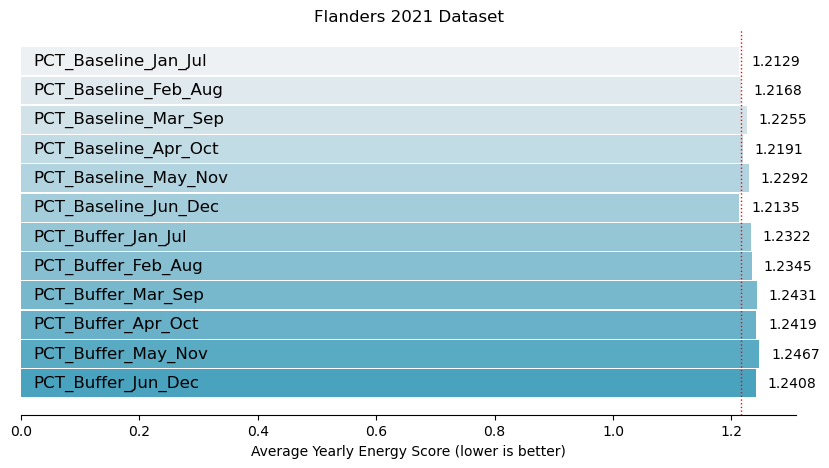

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Mock example data
techniques = ['Random_Baseline', 'PCT_Baseline']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a new list with entries for each month
values = []
values.extend(energy_scores.mean(axis = 0).values.tolist())
techniques = [f'PCT_Baseline_{months[i]}_{months[i+6]}' for i in range(6)]
techniques.extend([f'PCT_Buffer_{months[i]}_{months[i+6]}' for i in range(6)])
# Define a list of colors (include more than 4 colors for potential future use)
base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)

# Use the first four colors for the current bars
#bar_colors = all_colors[:len(techniques)]

# Calculate positions for bars
bar_positions = np.arange(len(techniques))

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.2  # Adjust the width of the bars
bar_spacing = 0.01  # Adjust the spacing between the bars

bars = ax.barh(bar_positions * (bar_width + bar_spacing), values, color=palette, height=bar_width)

# Adding values and standard deviations at the end of each bar
for bar, technique, value,  in zip(bars, techniques, values):
    decimals = 4 if str(value)[::-1].find('.') >= 2 else 2
    value_text = f'{value:.{decimals}f}'
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar_width / 2, value_text, ha='left', va='center', fontsize=10, color='black')
    ax.text(bar.get_x() + 0.02, bar.get_y() + bar_width / 2, technique, ha='left', va='center', fontsize=12, color='black')

# Add a thin dotted red vertical line at the value of index 1 in the values list
ax.axvline(x=values[1], color='red', linestyle=':', linewidth=1)

# Customize plot
ax.set_yticks([])  # Remove y-axis ticks
ax.invert_yaxis()  # Invert y-axis to have the first technique at the top

# Remove box edges
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set labels and title
ax.set_xlabel('Average Yearly Energy Score (lower is better)')
ax.set_title('Flanders 2021 Dataset')
plt.savefig('pictures/energy_score_comparison_flanders_2buffers.png', bbox_inches='tight', dpi=300, transparent=True)
# Show plot
plt.show()


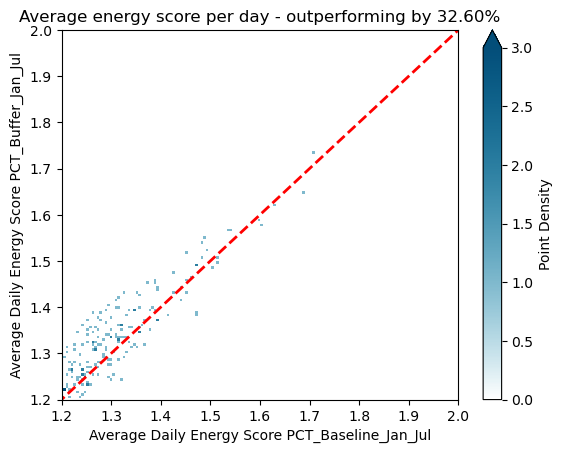

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

df_avg = energy_scores.groupby('date').mean()
technique_A = df_avg.iloc[:, 0]
technique_B = df_avg.iloc[:, 6]

# Increase bin size for a smoother heatmap
bin_size = 150

# Define the end color (#1D8DB0)
end_color = [0.114, 0.553, 0.690]  # RGB values

# Create a custom colormap starting from white to the end color with increased saturation
cmap_white_to_custom = LinearSegmentedColormap.from_list('white_to_custom', [(1, 1, 1), end_color], N=256)

# Create a modified colormap with increased saturation
cmap_white_to_custom_saturation = ListedColormap(cmap_white_to_custom(np.linspace(0, 1, 256))[:, :3] ** 2)

# Use the custom colormap in hist2d
heatmap = plt.hist2d(technique_A, technique_B, bins=bin_size, cmap=cmap_white_to_custom_saturation)

# Add a 45-degree line
plt.plot([0, 3], [0, 3], color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Average Daily Energy Score PCT_Baseline_Jan_Jul')
plt.ylabel('Average Daily Energy Score PCT_Buffer_Jan_Jul')
percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
plt.title(f'Average energy score per day - outperforming by {percentage_A_greater_than_B:.2f}%')

# Add colorbar with white indicating zero density
cbar = plt.colorbar(heatmap[3], label='Point Density', cmap=cmap_white_to_custom_saturation, extend='max')

plt.xlim(1.2, 2)
plt.ylim(1.2, 2)
# Show the plot
plt.savefig('pictures/flandersdailycomparison2buffers.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

In [20]:
for i in range(1,12):
    technique_A = df_avg.iloc[:, 0]
    technique_B = df_avg.iloc[:, i]
    percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
    percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
    print("lower in A: ", percentage_A_greater_than_B)

lower in A:  48.76712328767123
lower in A:  34.52054794520548
lower in A:  38.9041095890411
lower in A:  31.232876712328768
lower in A:  49.86301369863014
lower in A:  32.602739726027394
lower in A:  40.0
lower in A:  30.958904109589042
lower in A:  23.013698630136986
lower in A:  28.21917808219178
lower in A:  24.383561643835616


In [22]:
import pandas as pd
# Drop the first column by using its index as randombaseline should not be included
# Assuming energy_scores is your DataFrame

# Convert the index to a datetime object
energy_scores.index = pd.to_datetime(energy_scores.index)

# Extract the month from the datetime index
energy_scores['Month'] = energy_scores.index.month

# Initialize an empty DataFrame for the final table
monthly_means = pd.DataFrame()

# Calculate the mean for each month for each column
for month in range(1, 13):
    monthly_mean = energy_scores[energy_scores['Month'] == month].mean()
    monthly_means[month] = monthly_mean

# Drop the 'Month' row as it's not needed in the final table
monthly_means = monthly_means.drop('Month')
techniques = [f'PCT_Baseline_{months[i]}_{months[i+6]}' for i in range(6)]
techniques.extend([f'PCT_Buffer_{months[i]}_{months[i+6]}' for i in range(6)])
# Rename the index for clarity
monthly_means.index = techniques#['PCT January', 'PCT February', 'PCT March', 'PCT April', 'PCT May', 'PCT June', 'PCT July', 'PCT August', 'PCT September', 'PCT October', 'PCT November', 'PCT December']

# Rename the columns to represent months
monthly_means.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Display the table
display(monthly_means)


/var/folders/_3/h0p_y99n15v6k84rsz9x28h40000gn/T/ipykernel_69537/1123006866.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  monthly_means = monthly_means.drop('Month')


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline_Jan_Jul,1.293901,1.273173,1.237802,1.302855,1.269629,1.225425,1.210987,1.138176,1.196129,1.099359,1.111550,1.201469
PCT_Baseline_Feb_Aug,1.315913,1.297825,1.217676,1.331125,1.266562,1.238574,1.199545,1.130574,1.185677,1.118911,1.102627,1.204671
PCT_Baseline_Mar_Sep,1.302191,1.324212,1.264086,1.308788,1.291901,1.213614,1.199527,1.147287,1.204286,1.125079,1.134429,1.198596
PCT_Baseline_Apr_Oct,1.301423,1.285868,1.268177,1.304955,1.281335,1.238368,1.222983,1.141267,1.178685,1.114485,1.104844,1.191346
PCT_Baseline_May_Nov,1.316489,1.318123,1.253012,1.305147,1.288654,1.230848,1.202126,1.176013,1.209632,1.144361,1.116861,1.196170
PCT_Baseline_Jun_Dec,1.294692,1.284681,1.257352,1.300543,1.277520,1.224792,1.194632,1.129319,1.213603,1.085361,1.111088,1.195404
PCT_Buffer_Jan_Jul,1.281190,1.265367,1.255496,1.371478,1.320303,1.277732,1.228736,1.151476,1.218931,1.107620,1.102663,1.210285
PCT_Buffer_Feb_Aug,1.291975,1.277296,1.230490,1.362280,1.328149,1.276462,1.219011,1.142324,1.213721,1.169854,1.096984,1.210351
PCT_Buffer_Mar_Sep,1.287375,1.313812,1.270207,1.348275,1.334012,1.265196,1.228580,1.159057,1.184361,1.145273,1.171262,1.216260
PCT_Buffer_Apr_Oct,1.333855,1.301926,1.262416,1.313425,1.303570,1.284761,1.244679,1.153249,1.190363,1.143979,1.138847,1.236008


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming monthly_means is your DataFrame after calculating the means

# Function to normalize data and apply color gradient within each column
def color_gradient(val, min_val, max_val, base_val):
    dif_lower = base_val - min_val
    dif_higher = max_val - base_val
    if dif_lower < dif_higher:
        min_val -= (dif_higher - dif_lower)
    elif dif_higher < dif_lower:
        max_val += (dif_lower - dif_higher)
    
    # Normalize the value within the column
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    # Use RdYlGn colormap (Red to Green)
    color = plt.cm.RdYlGn_r(norm(val))  # _r reverses the colormap
    # Convert color to hex format
    return f'background-color: {mcolors.to_hex(color)}; color: black'

# Function to round values, apply color gradient, and conditionally bold text
def apply_style(x):
    base_val = x[0]  # Assuming the first value is the baseline
    styled_cells = []
    for i, v in enumerate(x):
        style = color_gradient(v, min(x), max(x), base_val)
        if i >= 6 and v < x[i - 6]:
            style += '; font-weight: bold'
        styled_cells.append(f'{style}; text-align: right')
    return styled_cells

# Apply the color mapping and rounding to each cell within its column
styled_table = (monthly_means
                .round(5)
                .style
                .apply(apply_style, axis=0)
                .format("{:.5f}")
                .set_caption("<b style='font-size:15px;'>Average Monthly Energy Score Per Model (Rows) Per Month (Columns) With PCT_2Baselines Comparison</b>"))


# Display the styled table
styled_table


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline_Jan_Jul,1.29390,1.27317,1.23780,1.30285,1.26963,1.22543,1.21099,1.13818,1.19613,1.09936,1.11155,1.20147
PCT_Baseline_Feb_Aug,1.31591,1.29782,1.21768,1.33112,1.26656,1.23857,1.19955,1.13057,1.18568,1.11891,1.10263,1.20467
PCT_Baseline_Mar_Sep,1.30219,1.32421,1.26409,1.30879,1.29190,1.21361,1.19953,1.14729,1.20429,1.12508,1.13443,1.19860
PCT_Baseline_Apr_Oct,1.30142,1.28587,1.26818,1.30496,1.28134,1.23837,1.22298,1.14127,1.17868,1.11449,1.10484,1.19135
PCT_Baseline_May_Nov,1.31649,1.31812,1.25301,1.30515,1.28865,1.23085,1.20213,1.17601,1.20963,1.14436,1.11686,1.19617
PCT_Baseline_Jun_Dec,1.29469,1.28468,1.25735,1.30054,1.27752,1.22479,1.19463,1.12932,1.21360,1.08536,1.11109,1.19540
PCT_Buffer_Jan_Jul,1.28119,1.26537,1.25550,1.37148,1.32030,1.27773,1.22874,1.15148,1.21893,1.10762,1.10266,1.21028
PCT_Buffer_Feb_Aug,1.29197,1.27730,1.23049,1.36228,1.32815,1.27646,1.21901,1.14232,1.21372,1.16985,1.09698,1.21035
PCT_Buffer_Mar_Sep,1.28737,1.31381,1.27021,1.34828,1.33401,1.26520,1.22858,1.15906,1.18436,1.14527,1.17126,1.21626
PCT_Buffer_Apr_Oct,1.33385,1.30193,1.26242,1.31342,1.30357,1.28476,1.24468,1.15325,1.19036,1.14398,1.13885,1.23601
